In [1]:
# ! pip install --upgrade --quiet pymilvus langchain langchain-community 'arize-phoenix[evals]' langchainhub langchain-openai unstructured portkey-ai faiss-cpu
# ! zsh standalone_embed.sh start

In [1]:
from dotenv import load_dotenv
import os

load_dotenv()

OPENAI_API_KEY = os.environ["OPENAI_API_KEY"]
PORTKEY_API_KEY = os.environ["PORTKEY_API_KEY"]

In [2]:
import phoenix as px
session = px.launch_app()

/Users/yujian/Documents/workspace/ai_agents_cookbooks/aacb/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🌍 To view the Phoenix app in your browser, visit http://localhost:6006/
📖 For more information on how to use Phoenix, check out https://docs.arize.com/phoenix


In [3]:
from phoenix.trace.langchain import LangChainInstrumentor
LangChainInstrumentor().instrument()

In [4]:
from langchain_community.document_loaders import DirectoryLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain import hub
from langchain.tools.retriever import create_retriever_tool
from langchain_openai import ChatOpenAI

from portkey_ai import PORTKEY_GATEWAY_URL, createHeaders

import uuid

In [5]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1024, chunk_overlap=128)
loader = DirectoryLoader("../city_data")
docs = loader.load_and_split(text_splitter=text_splitter)

[nltk_data] Downloading package punkt to /Users/yujian/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/yujian/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [7]:
embeddings = OpenAIEmbeddings()
db = FAISS.from_documents(
    docs, 
    embeddings)

In [8]:
retriever = db.as_retriever()

In [9]:
tool = create_retriever_tool(
    retriever,
    "search_cities",
    "Searches and returns excerpts from Wikipedia entries of many cities.",
)
tools = [tool]

In [10]:
prompt = hub.pull("hwchase17/openai-tools-agent")
prompt.messages

[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], template='You are a helpful assistant')),
 MessagesPlaceholder(variable_name='chat_history', optional=True),
 HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['input'], template='{input}')),
 MessagesPlaceholder(variable_name='agent_scratchpad')]

In [11]:
portkey_headers = createHeaders(
    api_key=PORTKEY_API_KEY,
    trace_id=uuid.uuid4(),
    provider="openai",
    config="pc-basic-b390c9"
)

In [12]:
llm = ChatOpenAI(api_key=OPENAI_API_KEY, base_url=PORTKEY_GATEWAY_URL, default_headers=portkey_headers, temperature=0)

In [13]:
from langchain.agents import AgentExecutor, create_openai_tools_agent

agent = create_openai_tools_agent(llm, tools, prompt)
agent_executor = AgentExecutor(agent=agent, tools=tools)

In [16]:
result = agent_executor.invoke(
    {
        "input": "What landmarks should I visit in Paris?"
    }
)

In [17]:
from pprint import pprint

pprint(result["output"])

('Paris is known for its rich history and iconic landmarks. Some of the '
 'must-visit landmarks in Paris include:\n'
 '\n'
 '1. Notre Dame Cathedral: A masterpiece of French Gothic architecture located '
 'on the Île de la Cité.\n'
 '2. Eiffel Tower: An iconic symbol of Paris and one of the most visited '
 'landmarks in the world.\n'
 '3. Louvre Museum: One of the largest and most famous art museums in the '
 'world, housing the Mona Lisa and many other renowned artworks.\n'
 '4. Arc de Triomphe: A monumental arch at the western end of the '
 'Champs-Élysées, honoring those who fought and died for France.\n'
 '5. Sacré-Cœur Basilica: A stunning white-domed basilica located on the '
 'highest point in the city, offering panoramic views of Paris.\n'
 '6. Palace of Versailles: A magnificent royal palace located just outside of '
 'Paris, known for its opulent architecture and beautiful gardens.\n'
 '7. Montmartre: A historic neighborhood known for its artistic heritage, '
 'charming stre

![Screenshot 2024-05-10 at 9.50.27 PM.png](<attachment:Screenshot 2024-05-10 at 9.50.27 PM.png>)
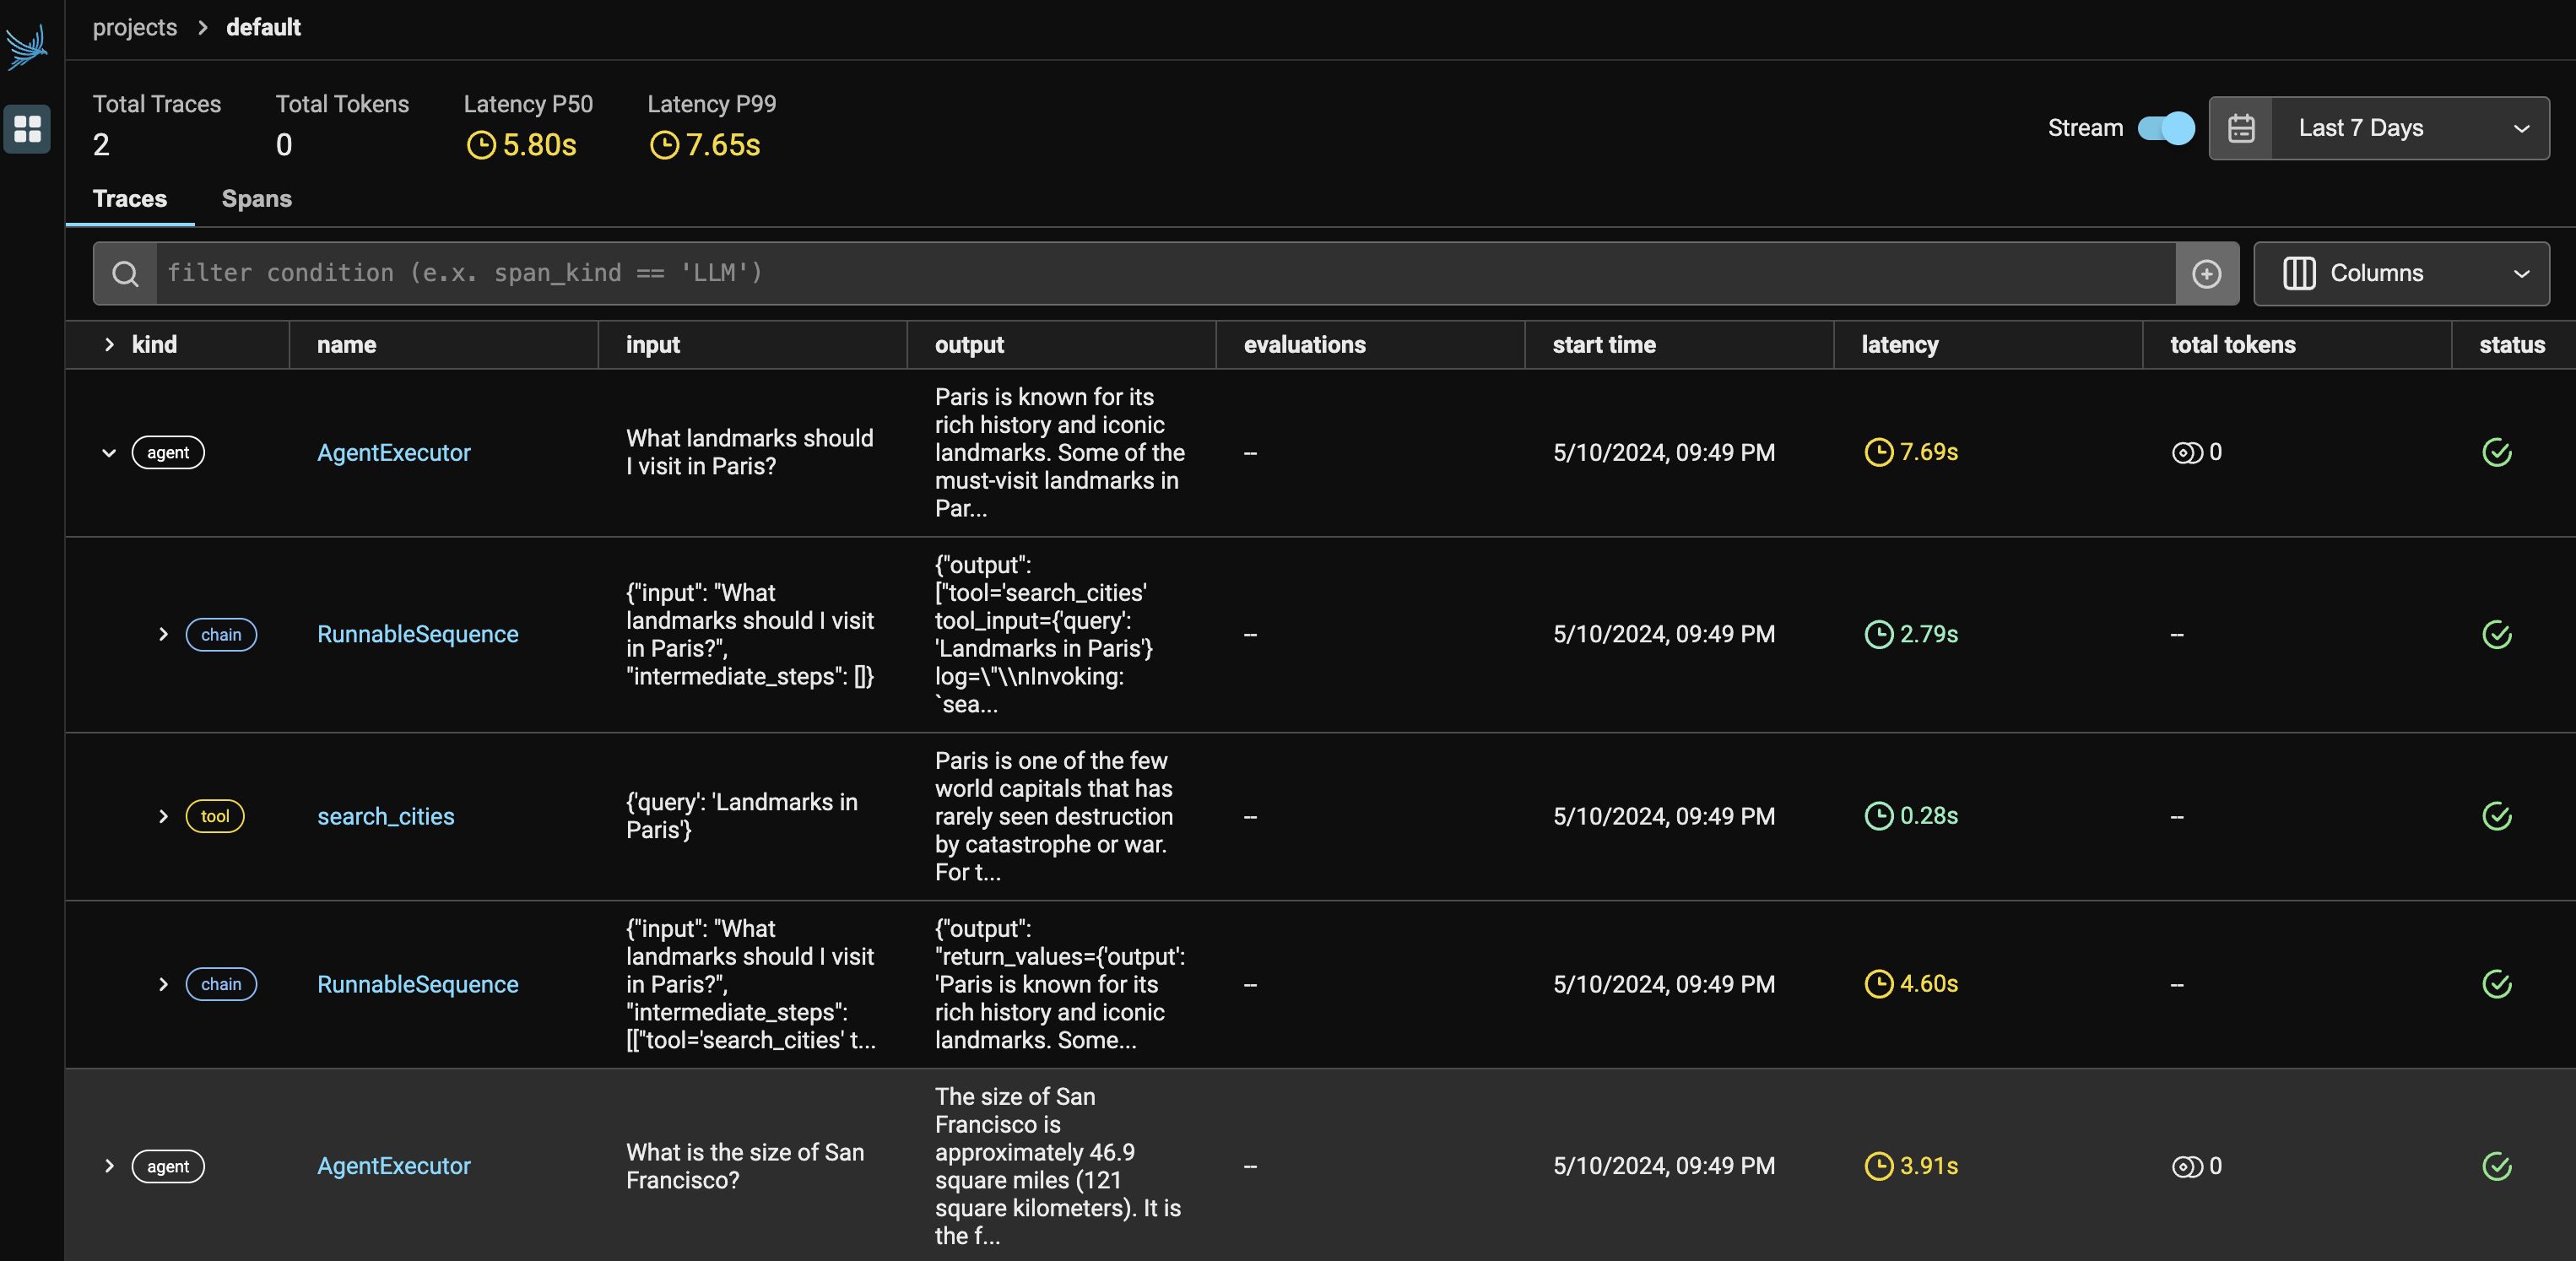